The point of this notebook is to demonstrate basic change using a time-series of dual polarization images using the Mahalanobis distance.

In [6]:
import rasterio
import tqdm
import leafmap
import geopandas as gpd
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import concurrent.futures
from mpire import WorkerPool
from skimage.restoration import denoise_tv_bregman
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.var import VAR
from pathlib import Path
import backoff
from urllib3.exceptions import HTTPError

# Load Burst and Denoise

We load all the bursts into memory - and it takes some time to do this.

After this setup, rerun and experiment as desired.

In [7]:
# BURST_ID = 'T126-269585-IW2' # forest
BURST_ID = 'T167-357346-IW1' # agriculture

In [8]:
df_rtc = pd.read_json('../4_rtc_organization/rtc_s1_table.json.zip')
df_rtc.head()

,rtc_s1_id,input_slc_id,jpl_burst_id,bursts_per_slc_input,rtc_s1_vv_url,rtc_s1_vh_url,rtc_s1_h5_url,acq_datetime
0,OPERA_L2_RTC-S1_T005-008688-IW2_20201010T00400...,S1A_IW_SLC__1SDV_20201010T004001_20201010T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-10 00:40:01
1,OPERA_L2_RTC-S1_T005-008688-IW2_20201022T00400...,S1A_IW_SLC__1SDV_20201022T004000_20201022T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-22 00:40:00
2,OPERA_L2_RTC-S1_T005-008688-IW2_20201103T00400...,S1A_IW_SLC__1SDV_20201103T004000_20201103T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-03 00:40:00
3,OPERA_L2_RTC-S1_T005-008688-IW2_20201115T00400...,S1A_IW_SLC__1SDV_20201115T004000_20201115T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-15 00:40:00
4,OPERA_L2_RTC-S1_T005-008688-IW2_20201127T00400...,S1A_IW_SLC__1SDV_20201127T004000_20201127T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-27 00:40:00


In [9]:
df_rtc_ts = df_rtc[df_rtc.jpl_burst_id == BURST_ID].reset_index(drop=True)

In [10]:
@backoff.on_exception(backoff.expo,
                      HTTPError,
                      max_tries=10,
                      max_time=60,
                      jitter=backoff.full_jitter)
def open_one(path: str) -> tuple:
    with rasterio.open(path) as ds:
        X = ds.read(1)
        p = ds.profile
    X = np.clip(X, 0, 1)
    return (X), p

def normalize_pol_ratio(img: np.ndarray, max_factor: float = 4.):
    vmax = max_factor
    vmin = 1e-7
    
    img_out = img.copy()
    img_out = np.clip(img_out, vmin, vmax)

    img_out = (img_out - vmin) / (vmax - vmin)    
    return img_out
    

def despeckle_one(X: np.ndarray, reg_param=2, noise_floor_db = -22) -> np.ndarray:
    X_c = np.clip(X, 1e-7, 1)
    X_db = 10 * np.log10(X_c, out=np.full(X_c.shape, np.nan), where=(~np.isnan(X_c)))
    X_db[np.isnan(X_c)] = noise_floor_db
    X_db_dspkl = denoise_tv_bregman(X_db, weight=.2, isotropic=True, eps=1e-3)
    X_dspkl = np.power(10, X_db_dspkl / 10.)
    X_dspkl[np.isnan(X)] = np.nan
    X_dspkl = np.clip(X_dspkl, 0, 1)
    return X_dspkl

In [11]:
df_rtc_ts.shape

(102, 8)

In [12]:
I = 0
K = df_rtc_ts.shape[0]

with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    data = list(tqdm(executor.map(open_one, df_rtc_ts.rtc_s1_vv_url[I:I + K]), total=K))
arrs_vv, profiles = zip(*data)

100%|███████████████████████████████| 102/102 [01:40<00:00,  1.01it/s]


In [13]:
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    data = list(tqdm(executor.map(open_one, df_rtc_ts.rtc_s1_vh_url[I:I + K]), total=K))
arrs_vh, _ = zip(*data)

100%|███████████████████████████████| 102/102 [01:42<00:00,  1.00s/it]


## Denoising / Despeckling

The TV denoising is much faster than the denoising.

In [14]:
with WorkerPool(n_jobs=10, use_dill=True) as pool:
    arrs_vv_d = pool.map(despeckle_one,
                         arrs_vv, 
                         progress_bar=True, 
                         progress_bar_style='notebook', 
                         concatenate_numpy_output=False)

  0%|                                         | 0/102 [00:00<?, ?it/s]

In [15]:
with WorkerPool(n_jobs=10, use_dill=True) as pool:
    arrs_vh_d = pool.map(despeckle_one, 
                         arrs_vh, 
                         progress_bar=True, 
                         progress_bar_style='notebook', 
                         concatenate_numpy_output=False)

  0%|                                         | 0/102 [00:00<?, ?it/s]

## Patch Read

In [16]:
df_patch_all = pd.read_json('../6_torch_dataset/dist_s1_patch_lut.json.zip')
df_patch_all.head()

,x_start,x_stop,y_start,y_stop,epsg,jpl_burst_id
0,2960,3184,200,424,32614,T005-008688-IW2
1,2980,3204,200,424,32614,T005-008688-IW2
2,3000,3224,200,424,32614,T005-008688-IW2
3,3020,3244,200,424,32614,T005-008688-IW2
4,2860,3084,220,444,32614,T005-008688-IW2


In [17]:
df_patches = df_patch_all[df_patch_all.jpl_burst_id == BURST_ID].reset_index(drop=True)
df_patches.head()

,x_start,x_stop,y_start,y_stop,epsg,jpl_burst_id
0,260,484,180,404,32636,T167-357346-IW1
1,280,504,180,404,32636,T167-357346-IW1
2,300,524,180,404,32636,T167-357346-IW1
3,320,544,180,404,32636,T167-357346-IW1
4,340,564,180,404,32636,T167-357346-IW1


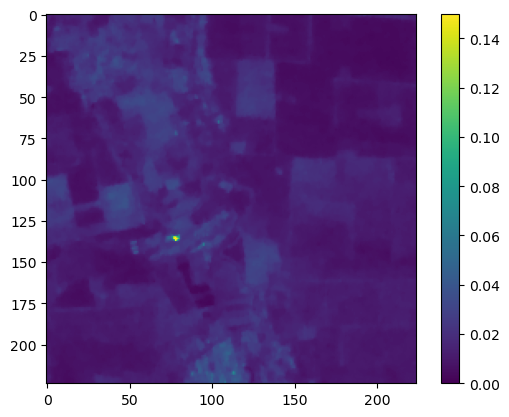

In [18]:
J = 2000
patches = df_patches.to_dict('records')
r = patches[J]

sy = np.s_[r['y_start']: r['y_stop']]
sx = np.s_[r['x_start']: r['x_stop']]

plt.imshow(arrs_vh_d[0][sy, sx], vmin=0, vmax=.15)
plt.colorbar()

# Mahalonobis 2d

Notes (WIP):

- As in the 1d case, we want to ensure that the distance $d$ defined as $d:= \sqrt{(x - \mu)^T \Sigma^{-1}(x - \mu)}$ does not explode due to small $\Sigma$ values ("small" requires some explanation since we are dealing with a matrix rather than a scalar value). In the 1d case, we swapped out $\sigma$ with $\widehat \sigma : = \max (\sigma, .01)$. Here we have a similar approach. We perform this "clipping" operation on the eigenvalues of $\Sigma$. I use the word "clip" here because of `np.clip`, but formally this is `maximum`.
- Because $\Sigma$ is the covariance here, the eigenvalues are really the *square-root* of the 1d case. Thus, $.01$ for $\sigma$ in 1d is actually $.0001 = .01^2$ in this 2d case.
- To do this "clipping", we need to compute eigenvectors/eigenvalues for each pixel. This can be done relatively quickly (i.e. by vectorized computation) because there are formulae for finding the eigenvalues and eigenvectors for symmetric $2 \times 2$ matrices (this would be  more difficult even in the 3 $\times$ 3 case).
- All statistics are collected in a $3 \times 3$ spatial patch and through time.
- In the 1d case, we stored the pre-images as a list of images. To assist in vectorized speedup, we store the preimages as a huge array. Specifically as $T \times 2 \times H \times W$, where T is the temporal dimension, 2 is dual polarization, and the $H \times W$ are the spatial dimensions. The covariance matrix (sampled over time and the local patch) will have size $2 \times 2 \times H \times W$.
- The eignevalue lower bound that we are using has the following effect: if we use approximately the same bound as before (namely $\sqrt 2 \cdot .0001$), then we see we that we are multipying $\mathbf{x}_{vv, vh} - \mu$ by $c\mathbf I$ for $c \in \mathbb R$, that is the covariance computation has little effect on differentiating VV and VH. If we reduce the threshold (i.e. make it smaller), then we can see that our distance metric has greater sensitivity to changes in $VH$ than VV. In other words, smaller (absolute) variations in VH impact our distance metric more than the same variations in VV. This "clipping" parameter impacts the distance metric and hence the changes we are observing. Another approach to clipping threshold is to use the noise floor. For Sentinel-1, the value is -22 db and this translates to $\approx 6.309e-3$.
- Another hyper-paramter is the window size - the larger the window size, presumably the more likely we are to include statistics irrelevant to the given pixel we are evaluating. However, depending on the size of the temporal window (i.e. the number of pre-images), increasing the window may provide some more insight into the expected qualitative statistics. We are using 3 x 3 windows, so each date has 9 pixels being sampled ~100 meters square or 1 ha.

In [70]:
from astropy.convolution import convolve

def get_spatiotemporal_mu_1d(arrs: np.ndarray,
                             kernel_width=3,
                             kernel_height=3) -> np.ndarray:
    k_shape = (1, kernel_height, kernel_width)
    kernel = np.ones(k_shape, dtype=np.float32) / np.prod(k_shape)
    
    mus_spatial = convolve(arrs, 
                           kernel, 
                           boundary="extend", 
                           nan_treatment='interpolate')
    mu_st = np.mean(mus_spatial, axis=0)
    return mu_st

def get_spatiotemporal_var_1d(arrs: np.ndarray,
                              mu_st=None,
                              kernel_width=3,
                              kernel_height=3
                              ) -> np.ndarray:
    if mu_st is None:
        mu_st = get_spatiotemporal_mu(arrs, 
                                      kernel_width=kernel_width, 
                                      kernel_height=kernel_height)
    
    k_shape = (1, kernel_height, kernel_width)
    kernel = np.ones(k_shape, dtype=np.float32) / np.prod(k_shape)
    
    var_s = convolve((arrs - mu_st)**2, 
                     kernel, 
                     boundary="extend", 
                     nan_treatment='interpolate')
    var_st = np.mean(var_s, axis=0) 
    return var_st

def get_spatiotemporal_cor(arrs: np.ndarray,
                                mu_st=None,
                                kernel_width=3,
                                kernel_height=3
                              ) -> np.ndarray:
    _, C, _, _ = arrs.shape
    if C != 2:
        raise ValueError('input arrs must have 2 channels!')
    if mu_st is None:
        mu_st = get_spatiotemporal_mu(arrs, 
                                      kernel_width=kernel_width, 
                                      kernel_height=kernel_height)
    CC, _, _ = mu_st.shape
    if CC != 2:
        raise ValueError('spatiotemporal mean must be 2!')
    
    k_shape = (1, kernel_height, kernel_width)
    kernel = np.ones(k_shape, dtype=np.float32) / np.prod(k_shape)

    covar_s = convolve((arrs[:, 0, ...] - mu_st[0, ...]) * (arrs[:, 1, ...] - mu_st[1, ...]), 
                       kernel, 
                       boundary="extend", 
                       nan_treatment='interpolate')
    covar_st = np.mean(covar_s, axis=0) 
    return covar_st


def get_spatiotemporal_mu(arrs: np.ndarray,
                             kernel_width=3,
                             kernel_height=3) -> np.ndarray:
    T, C, H, W = arrs.shape
    mu_st = np.full((C, H, W), np.nan)
    for c in range(C):
        mu_st[c,...] = get_spatiotemporal_mu_1d(arrs[:, c, ...])
    
    return mu_st

def get_spatiotemporal_covar(arrs: np.ndarray,
                              mu_st=None,
                              kernel_width=3,
                              kernel_height=3
                              ) -> np.ndarray:
    if mu_st is None:
        mu_st = get_spatiotemporal_mu(arrs, 
                                      kernel_width=kernel_width, 
                                      kernel_height=kernel_height)
    
    T, C, H, W = arrs.shape
    cov_st = np.full((C, C, H, W), np.nan)
    for c in range(C):
        cov_st[c, c,...] = get_spatiotemporal_var_1d(arrs[:, c, ...], 
                                                     mu_st=mu_st[c, ...], 
                                                     kernel_width=kernel_width, 
                                                     kernel_height=kernel_height)
    for c in range(C):
        for d in range(c, C):
            if c != d:

                covar_temp = get_spatiotemporal_cor(arrs[:, [c, d], ...], 
                                                    mu_st=mu_st[[c, d], ...], 
                                                    kernel_width=kernel_width, 
                                                    kernel_height=kernel_height)
                cov_st[c, d,...] = covar_temp
                cov_st[d, c,...] = covar_temp
    return cov_st

def invert_2d_cov(cov: np.ndarray) -> np.ndarray:
    det = cov[0, 0, ...] * cov[1, 1, ...] - 2 * cov[0, 1, ...]
    covar_inv = np.full(cov.shape, np.nan)
    covar_inv[0, 0, ...] = 1 / det * cov[1, 1, ...]
    covar_inv[1, 1, ...] = 1 / det * cov[0, 0, ...]
    t = - 1 / det * cov[0, 1, ...]
    covar_inv[0, 1, ...] = t
    covar_inv[1, 0, ...] = t
    return covar_inv

def get_eigh_2by2(cov_mat: np.ndarray) -> np.ndarray:
    """
    References:
    https://math.stackexchange.com/questions/395698/fast-way-to-calculate-eigen-of-2x2-matrix-using-a-formula
    https://people.math.harvard.edu/~knill/teaching/math21b2004/exhibits/2dmatrices/index.html
    """
    det = cov_mat[0, 0, ...] * cov_mat[1, 1, ...] -  cov_mat[0, 1, ...] * cov_mat[1, 0, ...]
    tr = cov_mat[0, 0, ...] + cov_mat[1, 1, ...]
    
    eigval = np.zeros((2, cov_mat.shape[2], cov_mat.shape[3]), dtype=np.float32)
    eigval[0, ...] = .5 * (tr + np.sqrt(tr**2 + 4 * det))
    eigval[1, ...] = .5 * (tr - np.sqrt(tr**2 + 4 * det))

    
    eigvec = np.zeros(cov_mat.shape)

    case_1 = (np.abs(cov_mat[0, 1, ...]) <= 1e-7)
    case_2 = ~case_1

    case_1_cov = cov_mat[..., case_1]
    case_1_eigval = eigval[:, case_1]
    
    case_2_cov = cov_mat[..., ~case_1]
    case_2_eigval = eigval[:, ~case_1]
    
    eigvec[0, 0, case_1] = case_1_eigval[0, ...] - case_1_cov[1, 1, ...]
    eigvec[1, 0, case_1] = case_1_cov[0, 1, ...]
    
    # Make sure the eigenvector is normalized so that the matrix of eigenvectors has an inverse that is its transpose
    n = np.sqrt(eigvec[1, 0, case_1] ** 2 + eigvec[0, 0, case_1]**2)
    eigvec[0, 0, case_1] /= n
    eigvec[1, 0, case_1] /= n

    eigvec[0, 1, case_1] = case_1_eigval[1, ...] - case_1_cov[1, 1, ...]
    eigvec[1, 1, case_1] = case_1_cov[1, 0, ...]

    # Make sure the eigenvector is normalized so that the matrix of eigenvectors has an inverse that is its transpose
    n = np.sqrt(eigvec[0, 1, case_1] ** 2 + eigvec[1, 1, case_1]**2)
    eigvec[0, 1, case_1] /= n
    eigvec[1, 1, case_1] /= n

    eigvec[0, 0, case_2] = 1
    eigvec[1, 1, case_2] = 1
    
    return eigval, eigvec


def get_mahalanobis_dist(pre_arrs: np.ndarray,
                         post_arr: np.ndarray,
                         kernel_width=3,
                         kernel_height=3,
                         eig_lb: float = .0001 * np.sqrt(2), #(1e-4 * 2 ** .5), #6.309e-3,#(.01 * 2 ** .5)
                        ) -> tuple[np.ndarray]:
                
    mu_st = get_spatiotemporal_mu(pre_arrs, 
                                  kernel_width=kernel_width, 
                                  kernel_height=kernel_height)
    covar_st = get_spatiotemporal_covar(pre_arrs, 
                                        mu_st=mu_st, 
                                        kernel_width=kernel_width, 
                                        kernel_height=kernel_height)

    eigval, eigvec = get_eigh_2by2(covar_st)
    # This is the floor we discused earlier except this is for the variance matrix so our LB is .01
    # We want the matrix norm to be at least .01 so we make sure each eigenvalue is .01 * \sqrt 2
    eigval_clip = np.maximum(eigval,  eig_lb)
    eigval_clip_inv = eigval_clip ** -1
    
    # Diag matrix is the diagonal matrix of eigenvalues
    diag_matrix = np.zeros(eigvec.shape, dtype=np.float32)
    diag_matrix[0, 0, ...] = eigval_clip_inv[0, ...] 
    diag_matrix[1, 1, ...] = eigval_clip_inv[1, ...]

    # Matrix multiplication to reconstruct the Sigma^-1  = V^T D V where V is the 
    # matrix whose colums are eignevectors and D is the diagonal matrix of eigenvalues
    covar_st_inv_floor_t = np.einsum('ijmn,jkmn->ikmn', diag_matrix, eigvec)
    covar_st_inv_floor = np.einsum('ijmn,jkmn->ikmn', eigvec.transpose([1, 0, 2, 3]), covar_st_inv_floor_t)
    
    # Finally compute the Mahalanobis distance!
    vec = post_arr - mu_st
    dist_0 = np.einsum('ijkl,jkl->ikl', covar_st_inv_floor, vec)
    dist_1 = np.einsum('ijk,ijk->jk', vec, dist_0)
    dist = np.sqrt(dist_1)
    return mu_st, covar_st, covar_st_inv_floor, dist, eigval

In [71]:
dual_pol = [np.stack([vv, vh], axis=0) for (vv, vh) in zip(arrs_vv_d, arrs_vh_d)]
ts = np.stack(dual_pol, axis=0)
ts.shape

(102, 2, 1477, 3305)

In [72]:
P = 25 # start
Q = 10 # number of preimages
pre = ts[P: P + Q, ...]
post = ts[P + Q , ...]
post.shape

(2, 1477, 3305)

In [74]:
m, c, cinv_c, d, _ = get_mahalanobis_dist(pre, post)

https://math.stackexchange.com/questions/395698/fast-way-to-calculate-eigen-of-2x2-matrix-using-a-formula
https://people.math.harvard.edu/~knill/teaching/math21b2004/exhibits/2dmatrices/index.html

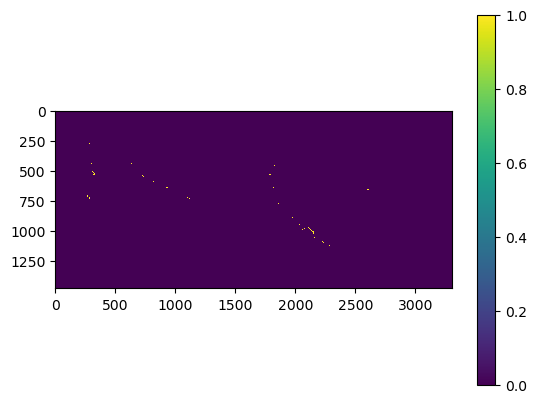

In [75]:
plt.imshow(d > 3, interpolation='none', vmin=0, vmax=1)
plt.colorbar()


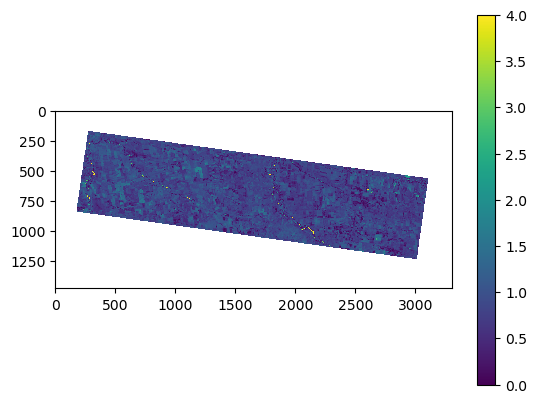

In [76]:
plt.imshow(d, interpolation='none', vmin=0, vmax=4)
plt.colorbar()

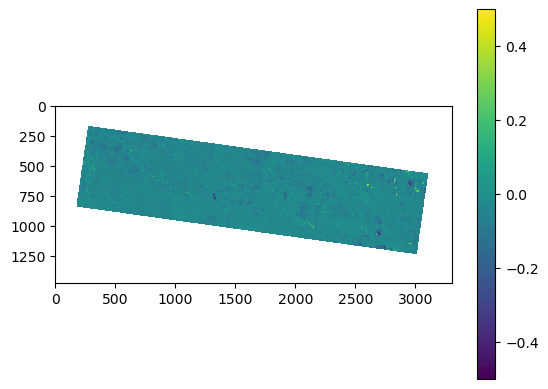

In [77]:
plt.imshow(post[0, ...] - m[0, ...], interpolation='none', vmin=-.5, vmax=.5)
plt.colorbar()

In [ ]:
plt.imshow(post[1, ...] - m[1, ...], interpolation='none', vmin=-.1, vmax=.1)
plt.colorbar()

# Serialize Data

In [55]:
out_dir = Path('out')

burst_dir = out_dir / BURST_ID 

vv_dir = burst_dir / 'vv'
vh_dir = burst_dir / 'vh'
dist_dir = burst_dir / 'dist' / f'start{P}_stop{Q}'

vv_dir.mkdir(exist_ok=True, parents=True)
vh_dir.mkdir(exist_ok=True, parents=True)
dist_dir.mkdir(exist_ok=True, parents=True)

In [56]:
with rasterio.open(df_rtc_ts.rtc_s1_vh_url[0]) as ds:
    profile_burst = ds.profile

In [57]:
def serialize_one(arr: np.ndarray, dst_path: Path) -> Path:
    #if dst_path.exists():
    #    return dst_path
    if True:
        with rasterio.open(dst_path, 'w', **profile_burst) as ds:
            ds.write(arr, 1)
    return dst_path

In [58]:
# vv
_ = [serialize_one(arr, vv_dir / url.split('/')[-1]) for (arr, url) in zip(arrs_vv_d, tqdm(df_rtc_ts.rtc_s1_vv_url[P: P + Q + 1]))]
_ = [serialize_one(arr, vh_dir / url.split('/')[-1]) for (arr, url) in zip(arrs_vh_d, tqdm(df_rtc_ts.rtc_s1_vh_url[P: P + Q + 1]))]

100%|█████████████████████████████████| 11/11 [00:01<00:00,  9.03it/s]


In [59]:
dist_dir / f'{df_rtc_ts.rtc_s1_vh_url[P + Q + 1].split("/")[-1]}'

PosixPath('out/T167-357346-IW1/dist/start25_stop10/OPERA_L2_RTC-S1_T167-357346-IW1_20210507T034730Z_20240428T232747Z_S1B_30_v1.0_VH.tif')

In [60]:
date_acq = df_rtc_ts.acq_datetime[P+Q+1].split(' ')[0]
date_acq

'2021-05-07'

In [61]:
serialize_one(d, dist_dir / f'dist_{date_acq}.tif')

PosixPath('out/T167-357346-IW1/dist/start25_stop10/dist_2021-05-07.tif')

# Visualize

## Mahalanobis distance

In [ ]:
plt.hist(d.ravel())
plt.grid('on')
plt.xlabel('Mahalonobis distance')
plt.ylabel('Frequency')

# Distribution in Patch

In [ ]:
# J = 2002
# patches = df_patches.to_dict('records')
# r = patches[J]

# sy = np.s_[r['y_start']: r['y_stop']]
# sx = np.s_[r['x_start']: r['x_stop']]

start_y= 500
start_x = 900
size = 10

sy = np.s_[start_y: start_y+size]#1000]
sx = np.s_[start_x: start_x+ size]#2000]

In [ ]:
mask = np.zeros(arrs_vh_d[0].shape)
mask[arrs_vh_d[0] > 0] = 1
mask[sy, sx] = 2
plt.imshow(mask, vmin=0, vmax=2, interpolation='none')
plt.axis('off')

In [ ]:
plt.imshow(arrs_vv_d[0][sy, sx], vmin=0, vmax=.6)
plt.colorbar()

In [ ]:
dates = (pd.to_datetime(df_rtc_ts.acq_datetime).dt.date.astype(str)).tolist()
dates[:2]

In [ ]:
N = pre.shape[0]
fig, ax = plt.subplots()
for i in range(N):
    date = dates[P + i]
    vv = pre[i, 0, sy, sx].ravel()
    vh = pre[i, 1, sy, sx].ravel()
    ax.scatter(vv, vh, alpha=.1, label=date)

date = dates[P+Q]
vv = post[0, sy, sx].ravel()
vh = post[1, sy, sx].ravel()
ax.scatter(vv, vh, alpha=.1, label=date)


ax.legend()
ax.set_xlim(-.01, .8)
ax.set_ylim(-.01, .25)
ax.set_xlabel('vv')
ax.set_ylabel('vh')

In [ ]:
T, _, H , W = pre.shape
pre_temp = pre[..., sy, sx].reshape((T, 2, -1)).transpose([0, 2, 1]).reshape((-1, 2))
pre_temp.shape

In [ ]:
cov_patch = np.cov(pre_temp, rowvar=False)
cov_patch

In [ ]:
cov_patch_inv = np.linalg.inv(cov_patch)
cov_patch_inv

In [ ]:
mu_patch = np.mean(pre_temp, axis=0)
mu_patch.shape

In [647]:
pre[:, 0, sy, sx].mean(), pre[:, 1, sy, sx].mean()

(0.057516581030078, 0.009286853694105077)

In [648]:
mu_patch

array([0.05751658, 0.00928685])

In [649]:
eigenvalues, eigv = np.linalg.eigh(cov_patch)
eigenvalues

array([6.30540158e-06, 9.59042536e-04])

In [650]:
LB = .0001 * 2 ** .5
eigenvalues_clipped = np.maximum(eigenvalues, LB)
eigenvalues_clipped

array([0.00014142, 0.00095904])

In [651]:
D = np.diag(eigenvalues_clipped ** -1)
cov_patch_inv_clipped = eigv.T @ D @ eigv
cov_patch_inv_clipped

array([[ 1241.00397774, -1075.21451798],
       [-1075.21451798,  6872.77045311]])

In [652]:
np.linalg.norm(cov_patch_inv_clipped)

7147.533637085769

In [653]:
def m_dist(vv_val, vh_val):
    """Simple calculation of Mahalanobis distance"""
    vec = np.array([vv_val, vh_val]) - mu_patch
    d = vec @ cov_patch_inv_clipped @ vec.T
    return  np.sqrt(d)

In [654]:
def m_dist_v(vvs, vhs):
    """Vectorized Mahalanbois distance"""
    vec = np.stack([vvs, vhs], axis=0) - mu_patch[:, None]
    d = np.einsum('ij,jk->ik', cov_patch_inv_clipped, vec)
    d = np.einsum('ij,ij->j', vec, d) 
    return  np.sqrt(d)

Check they are the same!

In [655]:
m_dist_v(np.array([0]), np.array([1])), m_dist(0, 1)

(array([82.89965312]), 82.89965311638692)

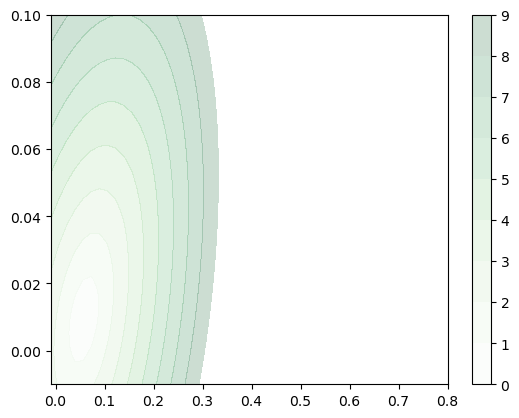

In [656]:
VV_LIM = -.01, .8
VH_LIM = -.01, .1
levels = np.arange(0, 10)

x = np.linspace(*VV_LIM)
y = np.linspace(*VH_LIM)
X, Y = np.meshgrid(x, y)
X_f, Y_f = X.ravel(), Y.ravel()
Z_f = m_dist_v(X_f, Y_f)
Z = Z_f.reshape(X.shape)
plt.contourf(X, Y, Z, alpha=.2, levels=levels, cmap='Greens')
plt.colorbar()

A change by $.1$ in VH vs. $.1$ in VV :

In [657]:
print('d\'s sensitivity to VH: ', m_dist(0, .1))
print('d\'s sensitivity to VV: ', m_dist(.1, 0))

d's sensitivity to VH:  8.478236228027649
d's sensitivity to VV:  1.9185895193977456


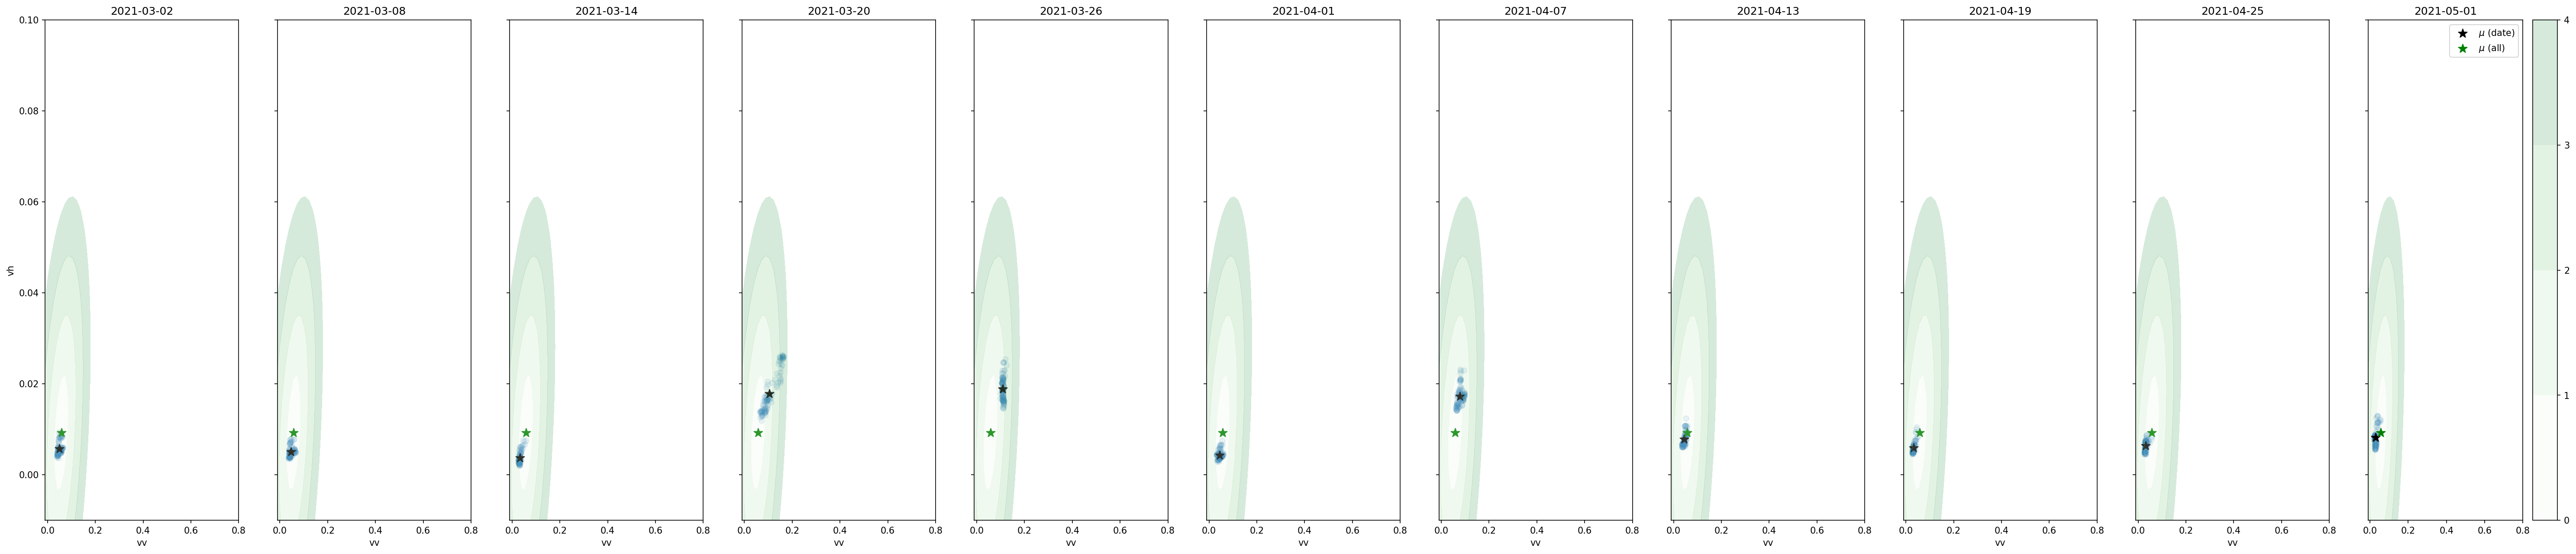

In [658]:

N = pre.shape[0]
fig, ax = plt.subplots(1, N+1, figsize=(50, 10), sharey=True, dpi=150)
levels = list(range(5))

for i in range(N):
    date = dates[P + i]
    vv = pre[i, 0, sy, sx].ravel()
    vh = pre[i, 1, sy, sx].ravel()
    mu_current = np.nanmean(vv), np.nanmean(vh)
    ax[i].scatter(vv, vh, alpha=.1)
    ax[i].scatter(*mu_current, marker='*', s=100, c='black', label='$\mu$ (current)')
    ax[i].scatter(*mu_patch, marker='*', s=100, c='green', label='$\mu$ (Pre-image)')
    ax[i].set_xlim(*VV_LIM)
    ax[i].set_ylim(*VH_LIM)
    ax[i].set_xlabel('vv')
    ax[i].contourf(X, Y, Z, alpha=.2, vmin=0, vmax=5, levels=levels, cmap='Greens')
    ax[i].set_title(date)
    if i == 0:
        ax[i].set_ylabel('vh')

date = dates[P+N]
vv = post[0, sy, sx].ravel()
vh = post[1, sy, sx].ravel()
ax[N].scatter(vv, vh, alpha=.1)
mu_current = np.nanmean(vv), np.nanmean(vh)

im = ax[N].contourf(X, Y, Z, alpha=.2, vmin=0, vmax=5, levels=levels, cmap='Greens')
ax[N].scatter(*mu_current, marker='*', s=100, c='black', label='$\mu$ (date)')
ax[N].scatter(*mu_patch, marker='*', s=100, c='green', label='$\mu$ (all)')
ax[N].legend()
ax[N].set_title(date)

fig.colorbar(im, ticks=levels)


2.398081733190338e-17


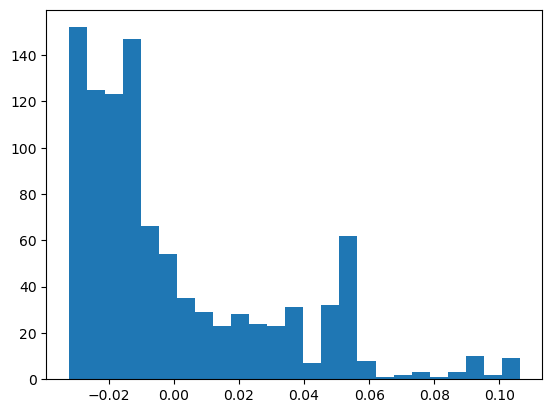

In [659]:
vv_pre_zero_mean = pre[:, 0, sy, sx].ravel() - mu_patch[0]
plt.hist(vv_pre_zero_mean, bins=25)
print(vv_pre_zero_mean.mean())

-1.5791812302268227e-17


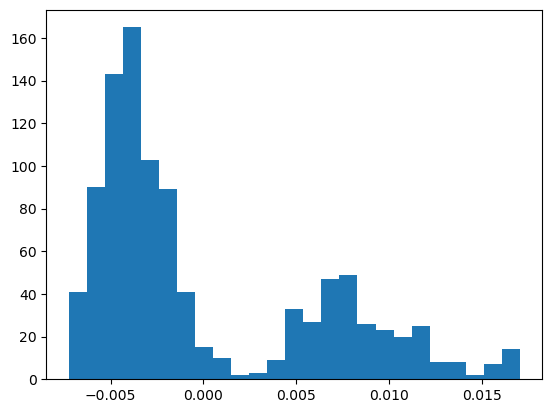

In [660]:
vh_pre_zero_mean = pre[:, 1, sy, sx].ravel() - mu_patch[1]
plt.hist(vh_pre_zero_mean, bins=25)
print(vh_zero_mean.mean())

-0.02762612938245774


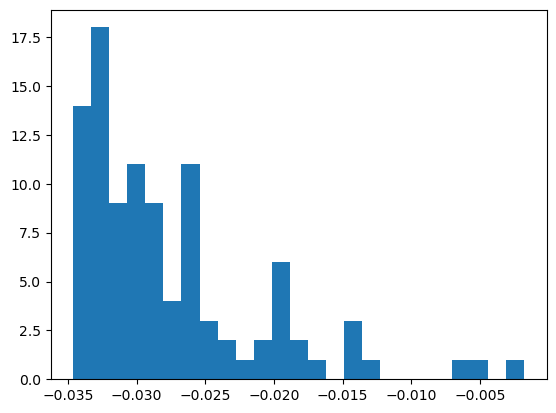

In [661]:
vv_post_n = post[0, sy, sx].ravel() - mu_patch[0]
plt.hist(vv_post_n, bins=25)
print(vv_post_n.mean())

-0.0011046115997458182


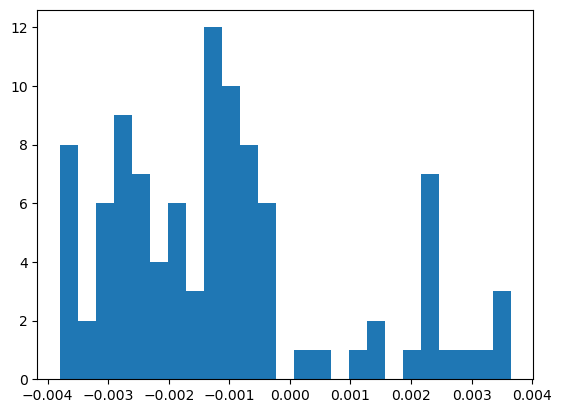

In [662]:
vh_post_n = post[1, sy, sx].ravel() - mu_patch[1]
plt.hist(vh_post_n, bins=25)
print(vh_post_n.mean())

(array([12., 92., 87., 56., 35., 57., 92., 86., 53., 46., 41., 35., 29.,
        16., 31., 25., 29., 38.,  8., 87., 15.,  2.,  4., 12., 12.]),
 array([-1.59794104, -1.56544894, -1.53295684, -1.50046474, -1.46797264,
        -1.43548054, -1.40298844, -1.37049634, -1.33800424, -1.30551214,
        -1.27302004, -1.24052794, -1.20803584, -1.17554374, -1.14305165,
        -1.11055955, -1.07806745, -1.04557535, -1.01308325, -0.98059115,
        -0.94809905, -0.91560695, -0.88311485, -0.85062275, -0.81813065,
        -0.78563855]),
 <BarContainer object of 25 artists>)

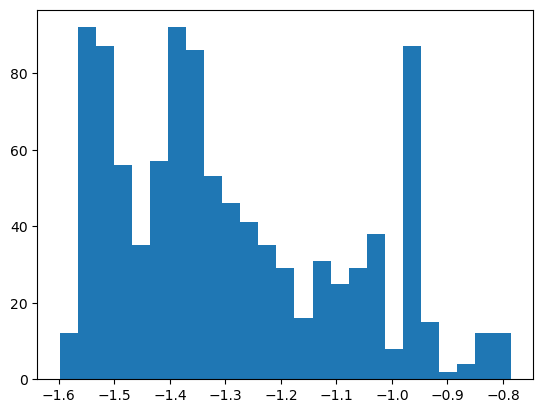

In [663]:
vv_pre_log = np.log10(pre[:, 0, sy, sx].ravel())
plt.hist(vv_pre_log, bins=25)

(array([  5.,   3.,  13.,  22.,  29.,  26.,  52.,  66., 100.,  89.,  72.,
         73.,  72.,  41.,  21.,   7.,   8.,   4.,  29.,  42.,  87.,  54.,
         46.,  16.,  23.]),
 array([-2.69205008, -2.64754508, -2.60304007, -2.55853507, -2.51403006,
        -2.46952506, -2.42502005, -2.38051505, -2.33601004, -2.29150504,
        -2.24700004, -2.20249503, -2.15799003, -2.11348502, -2.06898002,
        -2.02447501, -1.97997001, -1.935465  , -1.89096   , -1.84645499,
        -1.80194999, -1.75744498, -1.71293998, -1.66843497, -1.62392997,
        -1.57942497]),
 <BarContainer object of 25 artists>)

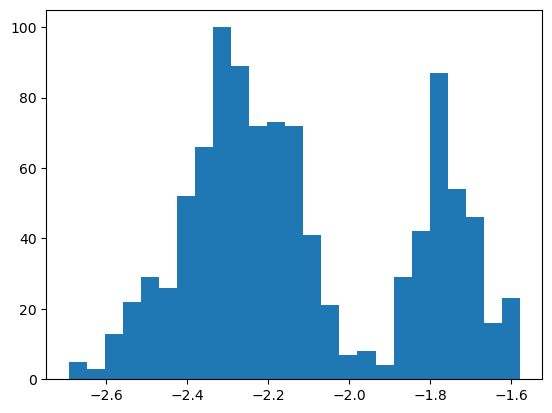

In [664]:
vh_pre_log = np.log10(pre[:, 1, sy, sx].ravel())
plt.hist(vh_pre_log, bins=25)

(array([ 4.,  5.,  1.,  4.,  5.,  9.,  4.,  3.,  6.,  3.,  8.,  9.,  7.,
        10.,  3.,  0.,  1.,  1.,  1.,  2.,  0.,  6.,  3.,  2.,  3.]),
 array([-2.26033281, -2.24544691, -2.23056102, -2.21567512, -2.20078923,
        -2.18590334, -2.17101744, -2.15613155, -2.14124565, -2.12635976,
        -2.11147386, -2.09658797, -2.08170207, -2.06681618, -2.05193028,
        -2.03704439, -2.0221585 , -2.0072726 , -1.99238671, -1.97750081,
        -1.96261492, -1.94772902, -1.93284313, -1.91795723, -1.90307134,
        -1.88818545]),
 <BarContainer object of 25 artists>)

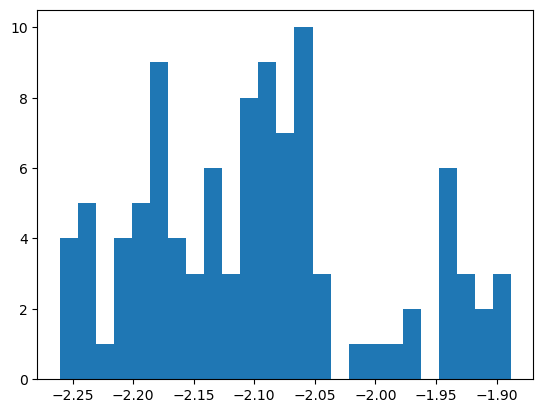

In [665]:
vh_post_log = np.log10(post[1, sy, sx].ravel())
plt.hist(vh_post_log, bins=25)

Text(0, 0.5, 'Frequency')

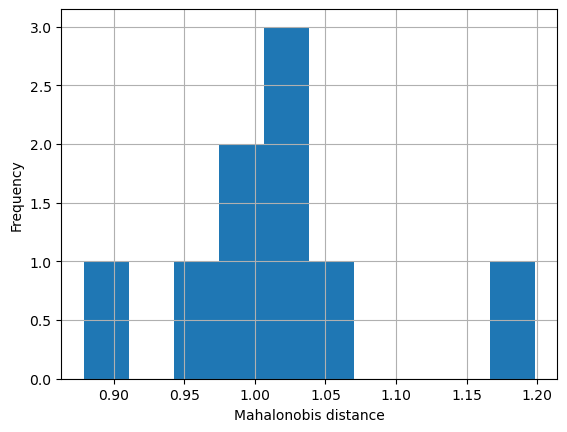

In [637]:
plt.hist(d[sy, sx].ravel())
plt.grid('on')
plt.xlabel('Mahalonobis distance')
plt.ylabel('Frequency')

In [548]:
import scipy.stats as stats
gamma_hh = stats.gamma.fit(gamm 